## Flight Delay Status Analysis in the U.S. during September 2017

By Hailey Brown and Matthew Straathof

## Introduction
Do you wonder about the best time of the week and hour of the day to fly when you're planning your next get-away? What days have the most traffic, least traffic? How often flights are delayed and when flights are most likely to be delayed? This tutorial will show you how to analyze flight data from the Bureau of Transportation Statistics. This data set has information about flights. First, we will show you how to import the data into a pandas dataframe and clean the data. Then we will do some exploratory data analysis to peer further into our data set. Then, based on this exploration, we will create hypotheses and that we will evaluate by using machine learning techniques and statistcal hypothesis testing.

## Resources
You will need Python 3.5 and the data set which can be found here:



This is the pandas homepage:
http://pandas.pydata.org/index.html

Quickstart guide to numpy:
https://docs.scipy.org/doc/numpy-dev/user/quickstart.html

Sklearn homepage:
http://scikit-learn.org/stable/

Matplotlib Homepage:
https://matplotlib.org

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn import cross_validation
import sklearn.metrics
import warnings

In [54]:
# Loading our dataset into a pandas dataframe
airline_df = pd.read_csv("613223610_T_ONTIME.csv")
# Print out first 5 rows in our dataframe
airline_df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,...,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 60
0,2017,9,25,1,2017-09-25,B6,20409,B6,N766JB,1036,...,NaN,1.0,68.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,9,25,1,2017-09-25,B6,20409,B6,N834JB,1038,...,211.0,1.0,1698.0,7,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,9,25,1,2017-09-25,B6,20409,B6,N834JB,1039,...,214.0,1.0,1698.0,7,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,9,25,1,2017-09-25,B6,20409,B6,N571JB,1041,...,99.0,1.0,718.0,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,9,25,1,2017-09-25,B6,20409,B6,N571JB,1042,...,93.0,1.0,718.0,3,NaN,NaN,NaN,NaN,NaN,NaN


# Our data
This give you a preview of what our data looks like. Some of the main points of our data are flight date, departure city, departure time, arrival city, arrival time, etc. The NaN values represent missing values in the data set.

# Tidying our data
As you can see, our dataframe has 46 columns, and some of these columns have values of NaN. We can tidy up our dataframe by seperating it up into multiple datasets, and by removing the columns that are not important to us.

Since our primary focus is to look at flight delays, and to try and find a coorelation between when a flight departed, we need to split the data up into flights that departed late and flights that departed on time. Pandas can let us easily do this.

In [55]:
flights = pd.DataFrame(airline_df[['DAY_OF_WEEK','FL_DATE','AIRLINE_ID','FL_NUM','ORIGIN','DEST','DEP_TIME','DEP_DELAY_NEW','DEP_DELAY_GROUP','ARR_TIME','ARR_DELAY_NEW','ARR_DELAY_GROUP','CANCELLED','DISTANCE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']])
flights.head()

,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY_NEW,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2017-09-25,20409,1036,SJU,STT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,68.0,NaN,NaN,NaN,NaN,NaN
1,1,2017-09-25,20409,1038,AUS,BOS,1801.0,0.0,-1.0,2303.0,0.0,-1.0,0.0,1698.0,NaN,NaN,NaN,NaN,NaN
2,1,2017-09-25,20409,1039,BOS,AUS,701.0,0.0,-1.0,958.0,0.0,-2.0,0.0,1698.0,NaN,NaN,NaN,NaN,NaN
3,1,2017-09-25,20409,1041,JFK,SAV,1552.0,0.0,-1.0,1813.0,0.0,-1.0,0.0,718.0,NaN,NaN,NaN,NaN,NaN
4,1,2017-09-25,20409,1042,SAV,JFK,1902.0,0.0,-1.0,2055.0,0.0,-2.0,0.0,718.0,NaN,NaN,NaN,NaN,NaN


# Further tidying
Now we have the columns that we want. We also need to remove the rows that have NaN values for the departure time, which is the column named "DEP_TIME." These flights were canceled, so they won't be included in our data sets for analysis. Then, we will break the data up further by seperating the late flights from the flights that arrived ontime.

In [56]:
flights['FL_DATE'] = pd.to_datetime(flights['FL_DATE'])
flights = flights.dropna(subset=['DEP_TIME'])
flights.head()

,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY_NEW,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
1,1,2017-09-25,20409,1038,AUS,BOS,1801.0,0.0,-1.0,2303.0,0.0,-1.0,0.0,1698.0,NaN,NaN,NaN,NaN,NaN
2,1,2017-09-25,20409,1039,BOS,AUS,701.0,0.0,-1.0,958.0,0.0,-2.0,0.0,1698.0,NaN,NaN,NaN,NaN,NaN
3,1,2017-09-25,20409,1041,JFK,SAV,1552.0,0.0,-1.0,1813.0,0.0,-1.0,0.0,718.0,NaN,NaN,NaN,NaN,NaN
4,1,2017-09-25,20409,1042,SAV,JFK,1902.0,0.0,-1.0,2055.0,0.0,-2.0,0.0,718.0,NaN,NaN,NaN,NaN,NaN
5,1,2017-09-25,20409,1043,DCA,CHS,700.0,0.0,0.0,844.0,4.0,0.0,0.0,444.0,NaN,NaN,NaN,NaN,NaN


In [57]:
late_flights = flights.loc[(flights['DEP_DELAY_NEW'] > 0)].copy()
ontime_flights = flights.loc[(flights['DEP_DELAY_NEW'] == 0)].copy()
late_flights.head()

,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY_NEW,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
13,1,2017-09-25,20409,1067,BOS,CHS,1404.0,5.0,0.0,1616.0,0.0,-1.0,0.0,818.0,NaN,NaN,NaN,NaN,NaN
18,1,2017-09-25,20409,1078,LAS,BOS,1219.0,14.0,0.0,2041.0,25.0,1.0,0.0,2381.0,14.0,0.0,11.0,0.0,0.0
24,1,2017-09-25,20409,1097,BOS,ATL,1003.0,51.0,3.0,1232.0,26.0,1.0,0.0,946.0,16.0,0.0,0.0,0.0,10.0
27,1,2017-09-25,20409,1100,MSY,BOS,1508.0,2.0,0.0,1916.0,0.0,-1.0,0.0,1368.0,NaN,NaN,NaN,NaN,NaN
28,1,2017-09-25,20409,1101,BOS,MSY,1156.0,6.0,0.0,1428.0,3.0,0.0,0.0,1368.0,NaN,NaN,NaN,NaN,NaN


In [58]:
ontime_flights.head()

,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY_NEW,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
1,1,2017-09-25,20409,1038,AUS,BOS,1801.0,0.0,-1.0,2303.0,0.0,-1.0,0.0,1698.0,NaN,NaN,NaN,NaN,NaN
2,1,2017-09-25,20409,1039,BOS,AUS,701.0,0.0,-1.0,958.0,0.0,-2.0,0.0,1698.0,NaN,NaN,NaN,NaN,NaN
3,1,2017-09-25,20409,1041,JFK,SAV,1552.0,0.0,-1.0,1813.0,0.0,-1.0,0.0,718.0,NaN,NaN,NaN,NaN,NaN
4,1,2017-09-25,20409,1042,SAV,JFK,1902.0,0.0,-1.0,2055.0,0.0,-2.0,0.0,718.0,NaN,NaN,NaN,NaN,NaN
5,1,2017-09-25,20409,1043,DCA,CHS,700.0,0.0,0.0,844.0,4.0,0.0,0.0,444.0,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis
Now that we have our data, lets start visualizing. First, we will graph the number of flights each day to take a look at what the flight traffic looks like overall during our time period, which is the month of Sepember in 2017. We will use the group by function to accomplish this.

More information here:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

Then, we will go through the same process with late flights and then graph the late flights to total flights ratio.
We'll be using the plot function in matplotplib primarily. 

For more info look here:
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot

And for more functions to explore look here:
https://matplotlib.org/api/pyplot_summary.html

In [59]:
#find total number of flights on a specific date
flights_grouped_date = flights.copy()
flights_grouped_date = flights_grouped_date.groupby(flights_grouped_date['FL_DATE'], \
                                                          as_index=True, group_keys=True).count().reset_index()
flights_grouped_date = flights_grouped_date.rename(index=str, columns={'FL_NUM' : 'COUNT'})
flights_grouped_date = flights_grouped_date.sort_values(by='FL_DATE')
flights_grouped_date[['FL_DATE', 'COUNT']].head()

,FL_DATE,COUNT
0,2017-09-01,15779
1,2017-09-02,11914
2,2017-09-03,12274
3,2017-09-04,15430
4,2017-09-05,15350


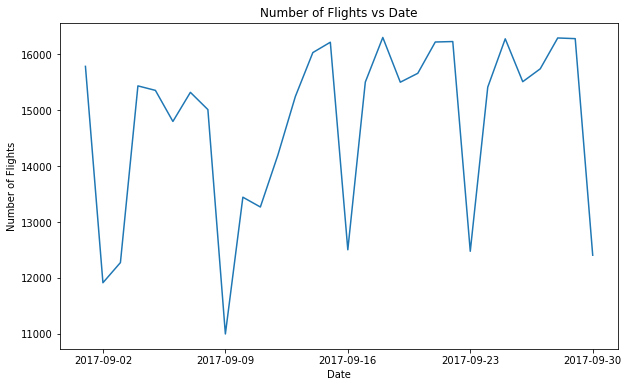

In [60]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot_date(flights_grouped_date['FL_DATE'], flights_grouped_date['COUNT'], '-')
plt.title('Number of Flights vs Date')
plt.ylabel('Number of Flights')
plt.xlabel('Date')
plt.show()

In [61]:
#find total number of late flights on a specific date
late_flights_grouped_date = late_flights.copy()
late_flights_grouped_date = late_flights_grouped_date.groupby(late_flights_grouped_date['FL_DATE'], \
                                                          as_index=True, group_keys=True).count().reset_index()
late_flights_grouped_date = late_flights_grouped_date.rename(index=str, columns={'AIRLINE_ID' : 'COUNT'})
late_flights_grouped_date = late_flights_grouped_date.sort_values(by='FL_DATE')
late_flights_grouped_date[['FL_DATE', 'COUNT']].head()

,FL_DATE,COUNT
0,2017-09-01,5822
1,2017-09-02,2880
2,2017-09-03,2314
3,2017-09-04,4037
4,2017-09-05,5394


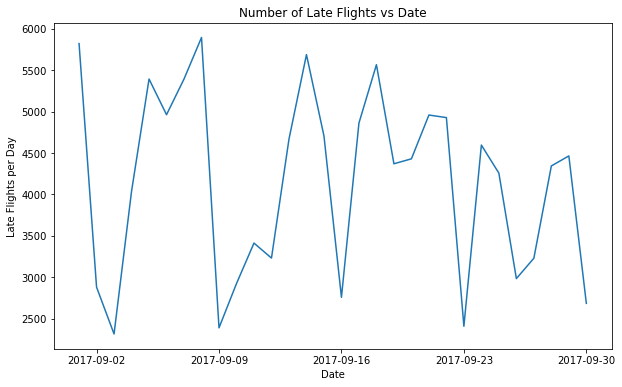

In [62]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot_date(late_flights_grouped_date['FL_DATE'], late_flights_grouped_date['COUNT'], '-')
plt.title('Number of Late Flights vs Date')
plt.ylabel('Late Flights per Day')
plt.xlabel('Date')
plt.show()

In [63]:
# Create dataframe with ratio of late flights to total flights for graphing
A = late_flights_grouped_date.copy()
B = flights_grouped_date.copy()
ratio = A.set_index('FL_DATE') / B.set_index('FL_DATE')
ratio = ratio.reset_index()

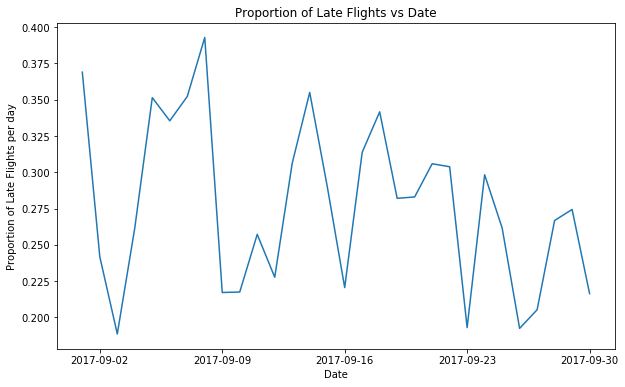

In [64]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot_date(ratio['FL_DATE'], ratio['COUNT'], '-')
plt.title('Proportion of Late Flights vs Date')
plt.ylabel('Proportion of Late Flights per day')
plt.xlabel('Date')
plt.show()

Comparing this graph with the previous 2 graphs, we can see there is a coorelation between airport traffic, and proption of flights delayed. This makes sense, since the busier the airport is, the harder it would be to get every plane out on time, causing planes to arrive late. We could also look at the hour of the day and day of the week to see if certain times of the day and days of week experience more delays than others.

Next we will explore flight delays and hour of the day. First, we will explore the total number of flights, then late flights and lastly the propotion of late flights to total flights, all by hour.

More info on the lambda function:
http://pandas.pydata.org/pandas-docs/version/0.18/generated/pandas.Series.apply.html

In [65]:
# group by hour
flights_hour = flights.copy()
flights_hour['HOUR'] = flights_hour['DEP_TIME'].apply(lambda t : int(t/100))
flights_hour[['DEP_TIME','HOUR']].head()

,DEP_TIME,HOUR
1,1801.0,18
2,701.0,7
3,1552.0,15
4,1902.0,19
5,700.0,7


In [66]:
flights_grouped_hour = flights_hour[['HOUR','DEP_TIME']].copy()
flights_grouped_hour = flights_grouped_hour.groupby(flights_grouped_hour['HOUR'], \
                                                          as_index=True, group_keys=True).count().reset_index()
flights_grouped_hour = flights_grouped_hour.rename(index=str, columns={'DEP_TIME':'COUNT'})
flights_grouped_hour = flights_grouped_hour.sort_values(by='HOUR')
flights_grouped_hour

,HOUR,COUNT
0,0,1702
1,1,531
2,2,109
3,3,50
4,4,938
5,5,14607
6,6,29892
7,7,27762
8,8,29801
9,9,25950


In [67]:
# hour 0 and 24 are the same, so combine the counts for those hours and delete row 24
flights_grouped_hour['COUNT'][0]
flights_grouped_hour['COUNT'][24]
flights_grouped_hour['COUNT'][0] = flights_grouped_hour['COUNT'][0] + flights_grouped_hour['COUNT'][24]
flights_grouped_hour = flights_grouped_hour.drop(flights_grouped_hour.index[24])
flights_grouped_hour

,HOUR,COUNT
0,0,1726
1,1,531
2,2,109
3,3,50
4,4,938
5,5,14607
6,6,29892
7,7,27762
8,8,29801
9,9,25950


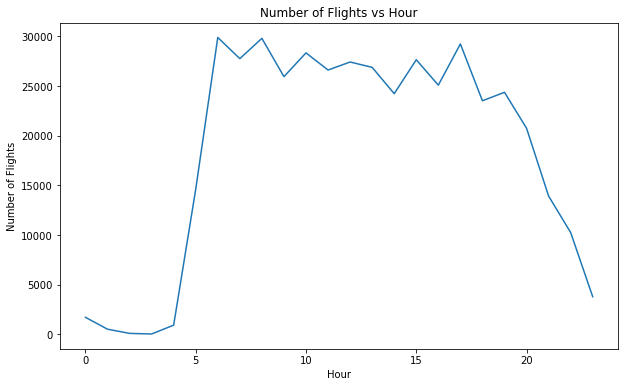

In [68]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(flights_grouped_hour['HOUR'], flights_grouped_hour['COUNT'], '-')
plt.title('Number of Flights vs Hour')
plt.ylabel('Number of Flights')
plt.xlabel('Hour')
plt.show()

From this plot we can see that the peak times to fly is around 6am to 10pm. There is a steady decline form 10pm to midnight. Then, there is a sharp increase in the number of flights from 4am to 6am. Also, we observe that there tends to be a slighly more flights earlier in the day than later in a day.

In [69]:
late_flights_hour = late_flights.copy()
late_flights_hour['HOUR'] = late_flights_hour['DEP_TIME'].apply(lambda t : int(t/100))
late_flights_hour.head()

,DAY_OF_WEEK,FL_DATE,AIRLINE_ID,FL_NUM,ORIGIN,DEST,DEP_TIME,DEP_DELAY_NEW,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,HOUR
13,1,2017-09-25,20409,1067,BOS,CHS,1404.0,5.0,0.0,1616.0,0.0,-1.0,0.0,818.0,NaN,NaN,NaN,NaN,NaN,14
18,1,2017-09-25,20409,1078,LAS,BOS,1219.0,14.0,0.0,2041.0,25.0,1.0,0.0,2381.0,14.0,0.0,11.0,0.0,0.0,12
24,1,2017-09-25,20409,1097,BOS,ATL,1003.0,51.0,3.0,1232.0,26.0,1.0,0.0,946.0,16.0,0.0,0.0,0.0,10.0,10
27,1,2017-09-25,20409,1100,MSY,BOS,1508.0,2.0,0.0,1916.0,0.0,-1.0,0.0,1368.0,NaN,NaN,NaN,NaN,NaN,15
28,1,2017-09-25,20409,1101,BOS,MSY,1156.0,6.0,0.0,1428.0,3.0,0.0,0.0,1368.0,NaN,NaN,NaN,NaN,NaN,11


In [70]:
late_flights_hour[['DEP_TIME','HOUR']].head()

,DEP_TIME,HOUR
13,1404.0,14
18,1219.0,12
24,1003.0,10
27,1508.0,15
28,1156.0,11


In [71]:
#find total number of late flights for each hour
late_flights_grouped_hour = late_flights_hour[['HOUR','DEP_TIME']].copy()
late_flights_grouped_hour = late_flights_grouped_hour.groupby(late_flights_grouped_hour['HOUR'], \
                                                          as_index=True, group_keys=True).count().reset_index()
late_flights_grouped_hour = late_flights_grouped_hour.rename(index=str, columns={'DEP_TIME':'COUNT'})
late_flights_grouped_hour = late_flights_grouped_hour.sort_values(by='HOUR')
late_flights_grouped_hour


,HOUR,COUNT
0,0,797
1,1,259
2,2,81
3,3,29
4,4,8
5,5,567
6,6,3273
7,7,4071
8,8,5374
9,9,5824


In [72]:
# hour 0 and 24 are the same, so combine the counts for those hours and delete row 24
late_flights_grouped_hour['COUNT'][0] = late_flights_grouped_hour['COUNT'][0] + late_flights_grouped_hour['COUNT'][24]
late_flights_grouped_hour = late_flights_grouped_hour.drop(late_flights_grouped_hour.index[24])
late_flights_grouped_hour

,HOUR,COUNT
0,0,820
1,1,259
2,2,81
3,3,29
4,4,8
5,5,567
6,6,3273
7,7,4071
8,8,5374
9,9,5824


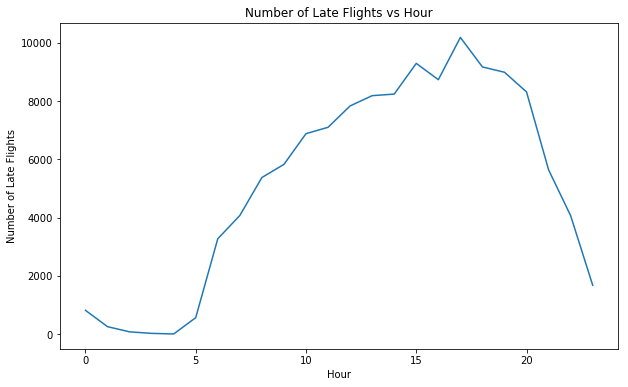

In [73]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(late_flights_grouped_hour['HOUR'], late_flights_grouped_hour['COUNT'], '-')
plt.title('Number of Late Flights vs Hour')
plt.ylabel('Number of Late Flights')
plt.xlabel('Hour')
plt.show()

From this plot, we can see that the flights are most often delayed are later in the day, with the most delays occurring around 5pm. Also, we observe that the number of delayed flights steadily increases throughout the day, which is the opposite of the result we found in the previous graph. 

In [74]:
A = late_flights_grouped_hour.copy()
B = flights_grouped_hour.copy()
res = A.set_index('HOUR') / B.set_index('HOUR')
res = res.reset_index()

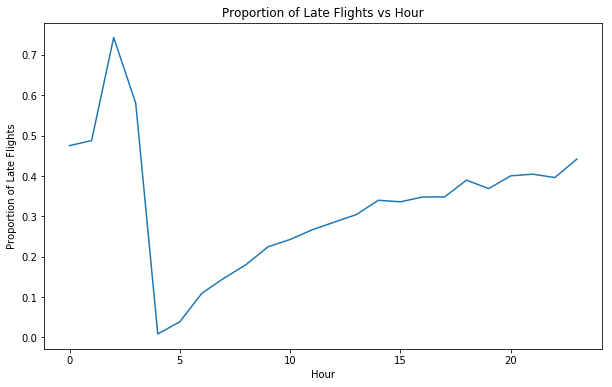

In [75]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(res['HOUR'], res['COUNT'], '-')
plt.title('Proportion of Late Flights vs Hour')
plt.ylabel('Proportion of Late Flights')
plt.xlabel('Hour')
plt.show()

This graph shows that the number of delayed flights steadily increases from 4am to 1am, spikes around 2am and then starts to plummet around 3am. From this graph, we learn that your flight is less likley to be delayed if you fly early in the day and much likelier to be dalyed if you fly late at night.

Next we will explore delayed flights by day of the week.

In [76]:
#find total number of flights on a specific date
flights_grouped_day = flights.copy()
flights_grouped_day = flights_grouped_day.groupby(flights_grouped_day['DAY_OF_WEEK'], \
                                                          as_index=True, group_keys=True).count().reset_index()
flights_grouped_day = flights_grouped_day.rename(index=str, columns={'AIRLINE_ID' : 'COUNT'})
flights_grouped_day = flights_grouped_day.sort_values(by='DAY_OF_WEEK')
flights_grouped_day[['DAY_OF_WEEK', 'COUNT']].head()

,DAY_OF_WEEK,COUNT
0,1,61263
1,2,60544
2,3,61425
3,4,63840
4,5,79492


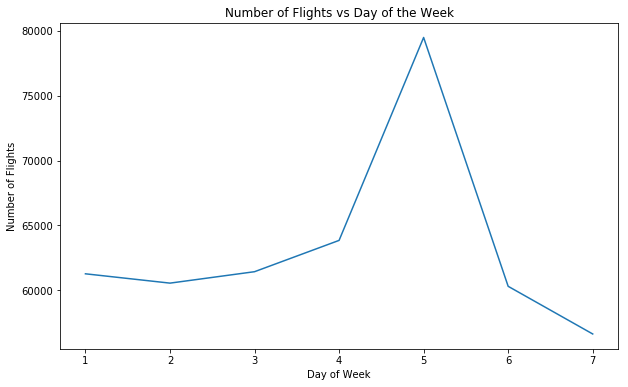

In [77]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(flights_grouped_day['DAY_OF_WEEK'], flights_grouped_day['COUNT'], '-')
plt.title('Number of Flights vs Day of the Week')
plt.ylabel('Number of Flights')
plt.xlabel('Day of Week')
plt.show()

In [78]:
#find total number of late flights on a specific date
late_flights_grouped_day = late_flights.copy()
late_flights_grouped_day = late_flights_grouped_day.groupby(late_flights_grouped_day['DAY_OF_WEEK'], \
                                                          as_index=True, group_keys=True).count().reset_index()
late_flights_grouped_day = late_flights_grouped_day.rename(index=str, columns={'AIRLINE_ID' : 'COUNT'})
late_flights_grouped_day = late_flights_grouped_day.sort_values(by='DAY_OF_WEEK')
late_flights_grouped_day[['DAY_OF_WEEK', 'COUNT']].head()

,DAY_OF_WEEK,COUNT
0,1,17273
1,2,15978
2,3,17289
3,4,20386
4,5,25818


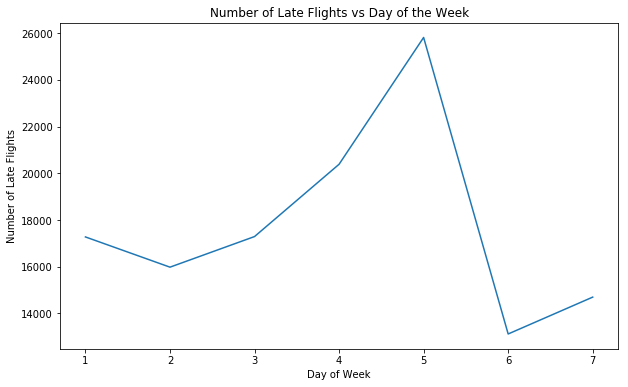

In [79]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(late_flights_grouped_day['DAY_OF_WEEK'], late_flights_grouped_day['COUNT'], '-')
plt.title('Number of Late Flights vs Day of the Week')
plt.ylabel('Number of Late Flights')
plt.xlabel('Day of Week')
plt.show()

In [80]:
A = late_flights_grouped_day.copy()
B = flights_grouped_day.copy()
res = A.set_index('DAY_OF_WEEK') / B.set_index('DAY_OF_WEEK')
res = res.reset_index()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


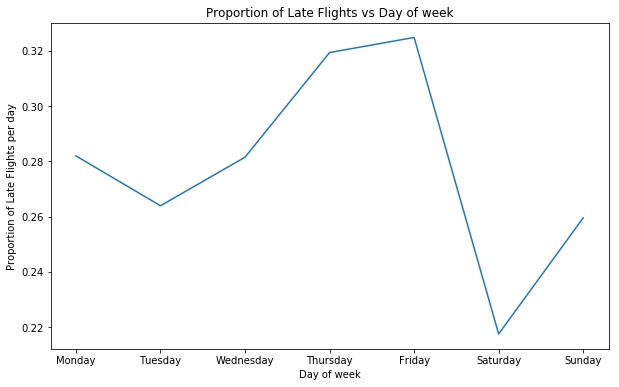

In [81]:
#plot the data
fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(res['DAY_OF_WEEK'], days)
plt.plot(res['DAY_OF_WEEK'], res['COUNT'], '-')
plt.title('Proportion of Late Flights vs Day of week')
plt.ylabel('Proportion of Late Flights per day')
plt.xlabel('Day of week')
plt.show()

We notice that the late flight to total flight ratio for Thursday is pretty high compared to the number of flights on Thursday and the ratio is relativley low for Saturday. So flying on a Saturday looks a like a good option. For all other days, the ratios look more reasonable.

# Machine Learning

Our goal for the machine learning section is to find a function that best predicts the delay time of a flight based on the hour of the day. Our hyperparameter will be the degree of the polynomial. For reference, first we will plot the average delay for each hour, and fit a polynomial to this scatter plot.

We will use numpy.polyfit to create our polynomials. https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html


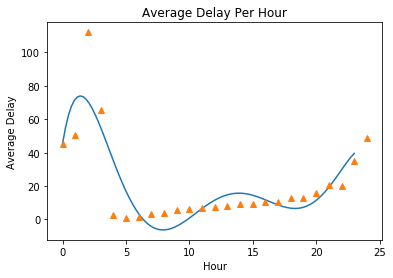

In [82]:
# group by hour and find average
average_delay_per_hour = flights_hour.groupby(['HOUR']).mean().reset_index()

#find a polynomial of best fit with degree 6
fit = np.polyfit(average_delay_per_hour['HOUR'], average_delay_per_hour['DEP_DELAY_NEW'], 6)
poly = np.poly1d(fit)

predicted_x = np.linspace(0,23, 100)
predicted_y = poly(predicted_x)
plt.plot(predicted_x, predicted_y)
plt.plot(average_delay_per_hour['HOUR'], average_delay_per_hour['DEP_DELAY_NEW'], '^')
plt.title('Average Delay Per Hour')
plt.ylabel('Average Delay')
plt.xlabel('Hour')
plt.show()

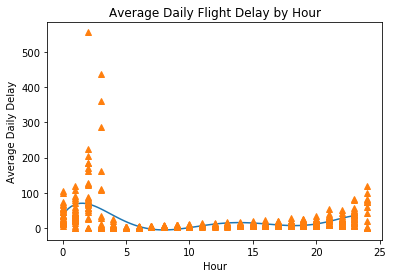

In [83]:
# Group our dataset by flight date and hour, and calculate the mean delay time during each hour of each day
hourly_flight_delays_by_day = flights_hour.groupby(['FL_DATE','HOUR']).mean().reset_index()

# Our initial prediction just through observation is that the best polynomial fit to this data with 
# be a polynomial of degree 6
fit = np.polyfit(hourly_flight_delays_by_day['HOUR'], hourly_flight_delays_by_day['DEP_DELAY_NEW'], 6)
poly = np.poly1d(fit)

predicted_x = np.linspace(0,23, 100)
predicted_y = poly(predicted_x)
plt.plot(predicted_x, predicted_y)
plt.plot(hourly_flight_delays_by_day['HOUR'], hourly_flight_delays_by_day['DEP_DELAY_NEW'], '^')
plt.title('Average Daily Flight Delay by Hour')
plt.ylabel('Average Daily Delay')
plt.xlabel('Hour')
plt.show()

Next we need to split our data into a training set and a testing set. We will train our machine learning algorithm only on the training set. Then we will use the testing set to test the prediction that the machine learning algorithm produced. We want the training set to be larger than the testing set of data so we split the data 2/3 to 1/3.

In [84]:
#randomly shuffle the data so we have different training and testing sets each time
flights_sample = hourly_flight_delays_by_day.copy().sample(frac=1)
cutoff = int(len(flights_sample)*(2/3))

#split the data into training and testing sets
flights_train = flights_sample[0:cutoff]
flights_test = flights_sample[cutoff::]

flights_train = flights_train.reset_index()

In [85]:
flights_train.head()

,index,FL_DATE,HOUR,DAY_OF_WEEK,AIRLINE_ID,FL_NUM,DEP_TIME,DEP_DELAY_NEW,DEP_DELAY_GROUP,ARR_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,CANCELLED,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,50,2017-09-03,2,7.0,20030.250000,821.750000,231.250000,51.750000,2.750000,647.500000,39.750000,2.250000,0.0,1485.500000,37.666667,0.000000,0.000000,0.0,15.333333
1,174,2017-09-08,4,5.0,19909.333333,1573.727273,454.090909,4.969697,-0.666667,666.000000,6.727273,-0.575758,0.0,637.696970,0.000000,0.000000,15.000000,0.0,82.000000
2,705,2017-09-30,8,6.0,19869.078699,1723.072403,831.172088,3.281217,-0.674711,1079.420776,3.637985,-0.910808,0.0,956.432319,38.230769,1.461538,9.576923,0.0,2.442308
3,95,2017-09-04,23,1.0,20073.143713,1599.275449,2329.239521,45.910180,2.089820,486.161677,41.813253,1.578313,0.0,1403.580838,18.793651,3.507937,7.174603,0.0,78.920635
4,108,2017-09-05,11,2.0,19893.248625,2055.398240,1129.273927,6.947195,-0.301430,1371.170517,7.568106,-0.527132,0.0,875.174917,17.112903,0.870968,19.395161,0.0,10.217742


Here we are using an algorithm to find the degree of the polynomial that best fits our data. The degree of the polynomial is called the hyperparameter. We will test polynomials between degree 1 and 15. Any polynomial with a degree higher than 15 would likely result in overfitting. For each degree, we will use the training data to create a polynomial, then test it against the testing dataset to determine the error of the polynomial. We will do this 7 times for each degree, splitting the data set differently each time, using K-Fold cross validation. Then we average the 7 error scores after the computation is completed for each degree. Then, after all the computation is complete for degrees 1 to 15, we will select the degree that has the least error on average. 

More on overfitting: 
http://blog.minitab.com/blog/adventures-in-statistics-2/the-danger-of-overfitting-regression-models

More on cross validation: 
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [86]:
#cross-validation

x_train = flights_train['HOUR']
y_train = flights_train['DEP_DELAY_NEW']

cv = cross_validation.KFold(len(x_train), n_folds=7)

validation_errors = []
train_errors = []
for degree in range(1,15):
    avg_train_error = 0
    avg_validation_error = 0
    for testcv, traincv in cv:
        #train our data with training subset
        cv_fit = np.polyfit(x_train[traincv], y_train[traincv], degree)
        cv_poly = np.poly1d(cv_fit)

        #test accuracy of data using squared error
        #training error
        predicted_train = cv_poly(x_train[traincv])
        train_error = (predicted_train - y_train[traincv])**2
        avg_train_error += np.mean(train_error)/7

        #validation error
        predicted_validation = cv_poly(x_train[testcv])
        validation_error = (predicted_validation - y_train[testcv])**2
        avg_validation_error += np.mean(validation_error)/7
    train_errors.append(avg_train_error)
    validation_errors.append(avg_validation_error)


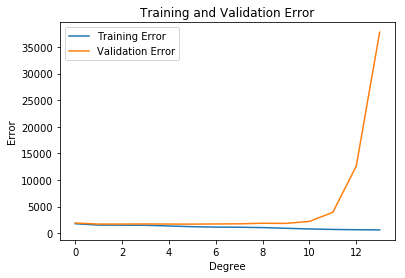

In [87]:
#plot it
plt.plot(train_errors, label='Training Error')
plt.plot(validation_errors, label='Validation Error')
plt.legend()
plt.title('Training and Validation Error')
plt.ylabel('Error')
plt.xlabel('Degree')
plt.show()

In [88]:
#find minimum error
deg = np.argmin(validation_errors)
deg
# this is the degree of the polynomial that produces the least error

5

In [89]:
#create optimal polynomial based on all training data
final_predictor = np.polyfit(x_train, y_train, deg)
final_poly = np.poly1d(final_predictor)

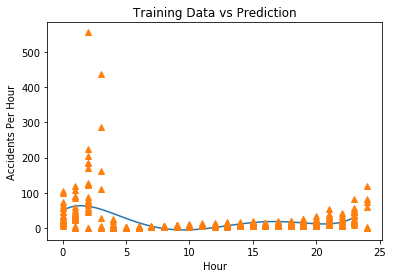

In [90]:
# Now plot our polynomial vs the training data
x_train = flights_train['HOUR']
y_train = flights_train['DEP_DELAY_NEW']
predicted_x = np.linspace(0,23, 100)
predicted_y = final_poly(predicted_x)
plt.plot(predicted_x, predicted_y)
plt.plot(x_train, y_train, '^')
plt.title('Training Data vs Prediction')
plt.ylabel('Accidents Per Hour')
plt.xlabel('Hour')
plt.show()

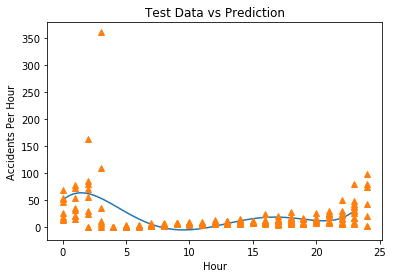

In [91]:
# Now plot our polynomial vs the test data
x_test = flights_test['HOUR']
y_test = flights_test['DEP_DELAY_NEW']
predicted_x = np.linspace(0,23, 100)
predicted_y = final_poly(predicted_x)
plt.plot(predicted_x, predicted_y)
plt.plot(x_test, y_test, '^')
plt.title('Test Data vs Prediction')
plt.ylabel('Accidents Per Hour')
plt.xlabel('Hour')
plt.show()

# Statistical Analysis

Now we will look at the square root of the mean squared error to measure the accuracy of the model. The result of this indicates that we are off about that many minutes on average with this model.

In [92]:
error = np.sqrt(np.mean((y_test - final_poly(x_test))**2))
error

27.90069441362332

The R-squared statistic is a fundamental statistical measure that measures the proportion of the variance in the dependent variable that is predictable from the independent variable. So, we can account for about that percent of the variance in the delay of flights based on the hour of the day, according to our model. This makes sense because there are many other factors affecting delayedness of a flight besides the time of day. However, we can confidently say that the time of day slightly affects the delayed status of a flight.

Information on R-squared here:
https://en.wikipedia.org/wiki/Coefficient_of_determination

In [93]:
r2 = sklearn.metrics.r2_score(y_test, final_poly(x_test))
r2

0.15556220007556221